In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import seaborn as sns
%matplotlib inline
import os
import pandas as pd
import json
import scipy

## 1. Propensity score matching

In [4]:
data = pd.read_csv('lalonde.csv')
data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


Observational study
We have 2 groups: "treated" vs "control"
The question is: was the treatment effective on the worker? That is, did it improved his earnings? did it depend on any of the other variables? (age, origin, marriage, education)
We need a way to measure effectiveness based on change in earnings

treatment assignment: Z = 1 (treated) and Z = 0 (control) -> treat
response if subject is treated: r_t -> how re78 differs from re74 and re75 (Z=1)
response if subject is control: r_c -> how re78 differs from re74 and re75 (Z=0)
observed covariates (features x) -> age, educ, black, hispan, married, nodegree
unobserved covariates ->  Naive model: exclude them because assume “Only observed variables determine treatment assignment”. Bad, naive model is almost never true. -> Use propensity score.
"Adjustments using a model attempt to compare people who are not directly
comparable — people of somewhat different ages or smoking habits — removing
these differences using a mathematical structure that has elements estimated from
the data at hand."


Propensity score -> "if naive model is true, it equals the probability to treat"
e(x) = P(Z=1|x)
Computed by logistic regression. Features x, label Z



In [5]:
# print the shape of the DataFrame
data.shape

(614, 11)

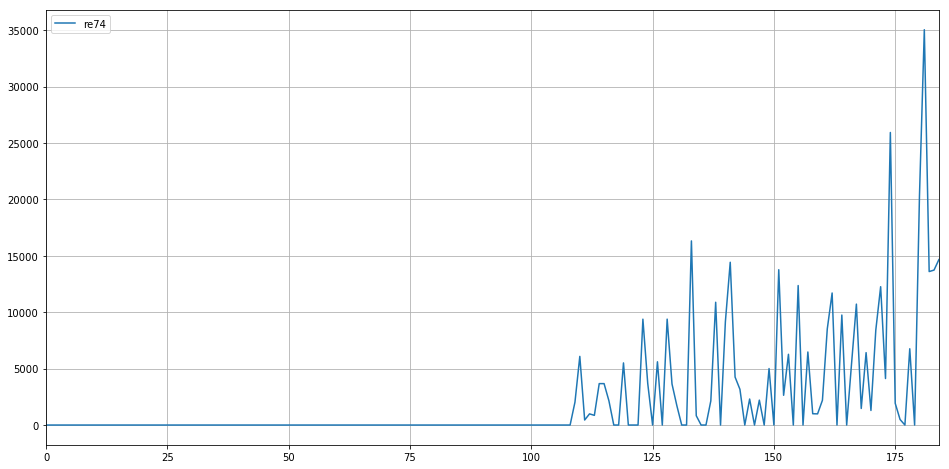

In [130]:
# plot salaries
data[data['treat'] == 1].plot(y='re74', figsize=(16, 8), grid=True)
#data[data['treat'] == 0].plot(y='diff', figsize=(16, 8), grid=True)


In [161]:
# compute the response
data[data['treat'] == 1].describe()


,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,diff
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530,2721.514528
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218,10305.398157
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-35621.008000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800,-276.083900
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000,1275.068400
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000,7739.440900
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000,59023.851000


In [35]:
data[data['treat'] == 0].describe()


,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,diff
count,429.0,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742,4517.685299
std,0.0,10.786653,2.855238,0.402552,0.349654,0.500419,0.491126,6788.750796,3291.996183,7294.161791,6917.542917
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-13776.530000
25%,0.0,19.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.181300,0.000000
50%,0.0,25.000000,11.000000,0.000000,0.000000,1.000000,1.000000,2547.047000,1086.726000,4975.505000,2688.385000
75%,0.0,35.000000,12.000000,0.000000,0.000000,1.000000,1.000000,9277.128000,3881.419000,11688.820000,8007.601100
max,0.0,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25862.320000,18347.230000,25564.670000,25564.670000


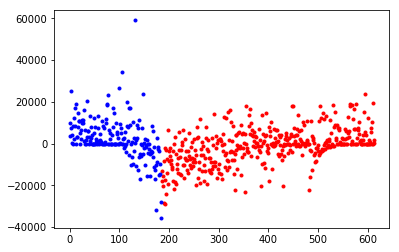

In [134]:
data['diff'] =  data['re78']-data['re75']-data['re74']
#plt.plot(data[data['treat'] == 0].loc[:, 're74'], 'r.', data[data['treat'] == 1].loc[:, 're74'], 'b.')
plt.plot(data[data['treat'] == 0].loc[:, 'diff'], 'r.', data[data['treat'] == 1].loc[:, 'diff'], 'b.')

In [170]:
 data[data['treat'] == 0].count()

id          429
treat       429
age         429
educ        429
black       429
hispan      429
married     429
nodegree    429
re74        429
re75        429
re78        429
diff        429
dtype: int64

In [188]:
treated = data[data['treat'] == 1].reset_index()
no_treated = data[data['treat'] == 0]
#data_to_plot = [treated, no_treated]
#plot = plt.boxplot(data_to_plot)


In [139]:
treated.re78

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,diff
0,NSW1,1,37,11,1,0,1,1,0.0000,0.000,9930.0460,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0000,0.000,3595.8940,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0000,0.000,24909.4500,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0000,0.000,7506.1460,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0000,0.000,289.7899,289.7899
5,NSW6,1,22,9,1,0,0,1,0.0000,0.000,4056.4940,4056.4940
6,NSW7,1,23,12,1,0,0,0,0.0000,0.000,0.0000,0.0000
7,NSW8,1,32,11,1,0,0,1,0.0000,0.000,8472.1580,8472.1580
8,NSW9,1,22,16,1,0,0,0,0.0000,0.000,2164.0220,2164.0220
9,NSW10,1,33,12,0,0,1,0,0.0000,0.000,12418.0700,12418.0700


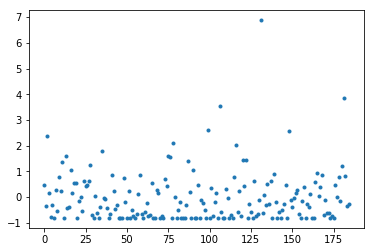

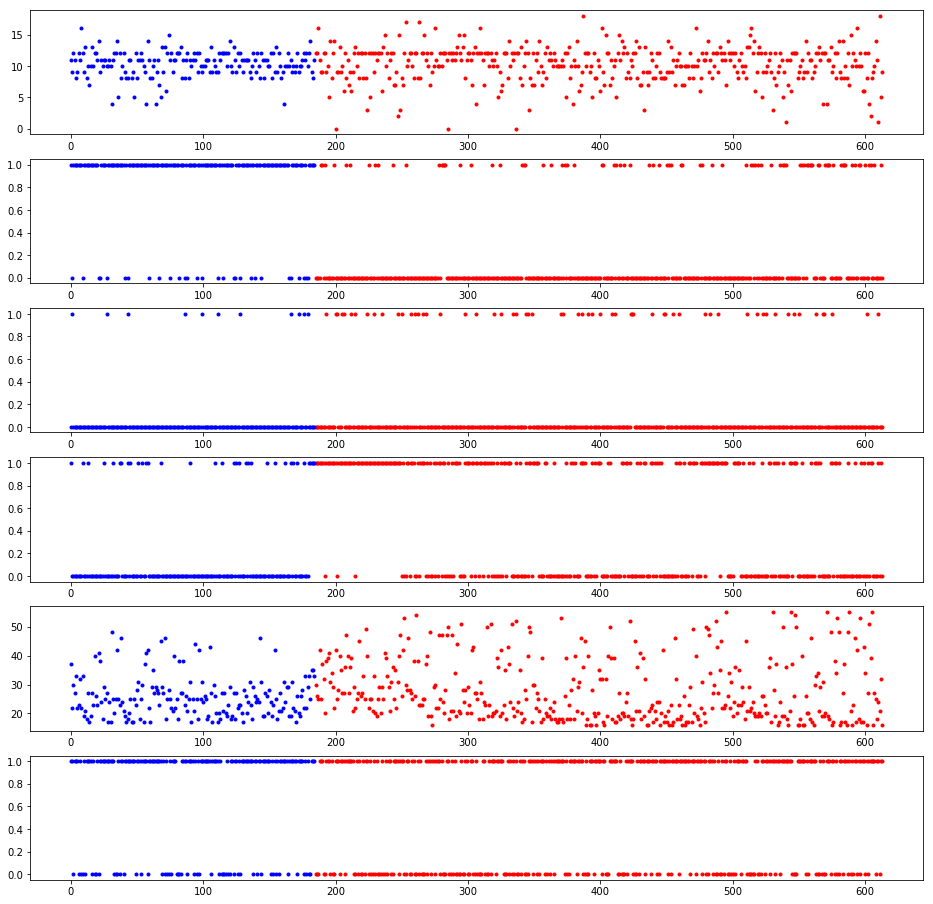

In [199]:
fig = plt.figure(figsize=(16, 1plt.plot(data[data['treat']==1].loc[:,'re78'],'.g')
plt.plot(data[data['treat']==0].loc[:,'re78'],'.r')6)) 
plt.subplot(6,1,1)
plt.plot(data[data['treat'] == 0].loc[:,'educ'],'.r')
plt.plot(data[data['treat'] == 1].loc[:,'educ'],'.b')
plt.subplot(6,1,2)
plt.plot(data[data['treat'] == 0].loc[:,'black'],'.r')
plt.plot(data[data['treat'] == 1].loc[:,'black'],'.b')
plt.subplot(6,1,3)
plt.plot(data[data['treat'] == 0].loc[:,'hispan'],'.r')
plt.plot(data[data['treat'] == 1].loc[:,'hispan'],'.b')
plt.subplot(6,1,4)
plt.plot(data[data['treat'] == 0].loc[:,'married'],'.r')
plt.plot(data[data['treat'] == 1].loc[:,'married'],'.b')
plt.subplot(6,1,5)
plt.plot(data[data['treat'] == 0].loc[:,'age'],'.r')
plt.plot(data[data['treat'] == 1].loc[:,'age'],'.b')
plt.subplot(6,1,6)
plt.plot(data[data['treat'] == 0].loc[:,'nodegree'],'.r')
plt.plot(data[data['treat'] == 1].loc[:,'nodegree'],'.b')

/Users/elisabettamessina/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/elisabettamessina/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


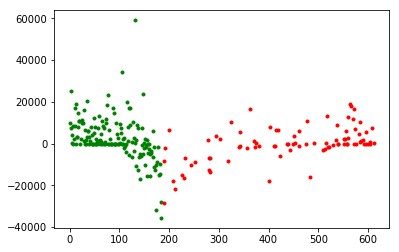

In [207]:

plt.plot(treated[data['black']==1].loc[:,'re78'],'.g')
plt.plot(no_treated[data['black']==1].loc[:,'re78'],'.r')

/Users/elisabettamessina/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


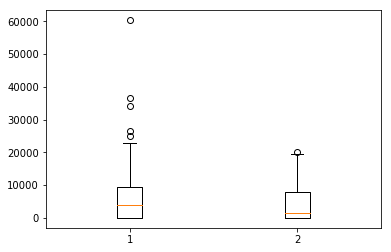

In [213]:
%matplotlib inline
data_to_plot = [treated[data['black']==1].loc[:,'re78'], no_treated[data['black']==1].loc[:,'re78']]
plot = plt.boxplot(data_to_plot)

In [216]:
import scipy.stats as stats

#We want to test if the medians differ significantly
stats.ttest_rel(a = treated[data['black']==1].loc[:,'re78'],
                b = no_treated[data['black']==1].loc[:,'re78'])

/Users/elisabettamessina/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/elisabettamessina/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ValueError: unequal length arrays

/Users/elisabettamessina/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


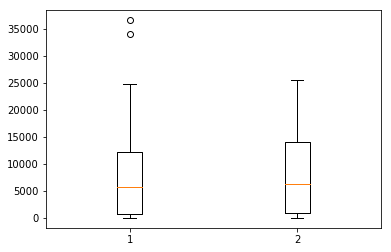

In [211]:
%matplotlib inline
data_to_plot = [treated[data['nodegree']==0].loc[:,'re78'], no_treated[data['nodegree']==0].loc[:,'re78']]
plot = plt.boxplot(data_to_plot)

In [218]:
from sklearn import linear_model
logistic = linear_model.LogisticRegression?

In [358]:
#features and labels
X = data.drop(['id', 'treat','re74','re75','re78','diff'],axis=1)
y = data.treat

In [359]:
logistic = linear_model.LogisticRegression()  # create the model
logistic.fit(X, y)  # train it

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [360]:
yhat = cross_val_predict(logistic, X, y, cv=5)

In [361]:
y = np.array(y)

In [372]:
 data['propens'] = logistic.predict_proba(X)[:,1]

In [371]:
logistic.predict_proba(X)

array([[ 0.52606123,  0.47393877],
       [ 0.79921494,  0.20078506],
       [ 0.35784757,  0.64215243],
       ..., 
       [ 0.88247745,  0.11752255],
       [ 0.5460302 ,  0.4539698 ],
       [ 0.87059452,  0.12940548]])

In [373]:
data

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,diff,propens
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,9930.0460,0.473939
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,3595.8940,0.200785
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,24909.4500,0.642152
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,7506.1460,0.695665
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,289.7899,0.677198
5,NSW6,1,22,9,1,0,0,1,0.0,0.0,4056.4940,4056.4940,0.693785
6,NSW7,1,23,12,1,0,0,0,0.0,0.0,0.0000,0.0000,0.650747
7,NSW8,1,32,11,1,0,0,1,0.0,0.0,8472.1580,8472.1580,0.689948
8,NSW9,1,22,16,1,0,0,0,0.0,0.0,2164.0220,2164.0220,0.667997
9,NSW10,1,33,12,0,0,1,0,0.0,0.0,12418.0700,12418.0700,0.044571


In [398]:
data[data['id']=='PSID422'].propens.values

array([ 0.12940548])

In [342]:
B_treated = list(treated.id)
B_nontreated=list(no_treated.id)

In [345]:
import networkx as nx
from networkx.algorithms import bipartite
B = nx.Graph()
B.add_nodes_from(B_treated, bipartite=0)
B.add_nodes_from(B_nontreated, bipartite=1)

In [406]:
%%time
for b_treated in B_treated:
    for b_nontreated in B_nontreated:
        wt =  -np.abs(data[data['id']==str(b_treated)].propens.values - data[data['id']==str(b_nontreated)].propens.values)
        B.add_edge(b_treated,b_nontreated,weight = wt)

CPU times: user 1min 51s, sys: 1.89 s, total: 1min 53s
Wall time: 1min 53s


In [436]:
len(Y)

429

"Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features "

In [455]:
%%time
d = nx.algorithms.max_weight_matching(B,maxcardinality=True)

CPU times: user 2min 53s, sys: 440 ms, total: 2min 54s
Wall time: 2min 54s


In [463]:
df = pd.DataFrame()
for key in d.keys():
    df = pd.concat([df, data[data['id']==key]])

/Users/elisabettamessina/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


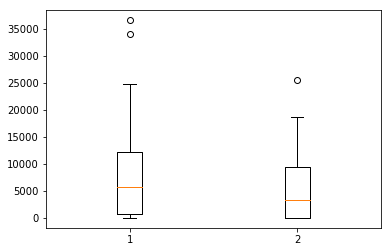

In [467]:
df_t = df[df['treat']==1]
df_nt = df[df['treat']==0]
data_to_plot = [df_t[data['nodegree']==0].loc[:,'re78'], df_nt[data['nodegree']==0].loc[:,'re78']]
plot = plt.boxplot(data_to_plot)

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
Your matching should maximize the similarity between matched subjects, as captured by their propensity scores. In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.
After matching, you have as many treated as you have control subjects.

In [311]:
#Check the error
classes = np.unique(y);
err = np.zeros(len(classes));

for c in range(len(classes)):
    err[c] = sum((y!=yhat) & (y == classes[c]))/sum(y==classes[c]);

err = np.mean(err);
err

0.2205884205884206

In [330]:
treated

,index,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,diff
0,0,NSW1,1,37,11,1,0,1,1,0.0000,0.000,9930.0460,9930.0460
1,1,NSW2,1,22,9,0,1,0,1,0.0000,0.000,3595.8940,3595.8940
2,2,NSW3,1,30,12,1,0,0,0,0.0000,0.000,24909.4500,24909.4500
3,3,NSW4,1,27,11,1,0,0,1,0.0000,0.000,7506.1460,7506.1460
4,4,NSW5,1,33,8,1,0,0,1,0.0000,0.000,289.7899,289.7899
5,5,NSW6,1,22,9,1,0,0,1,0.0000,0.000,4056.4940,4056.4940
6,6,NSW7,1,23,12,1,0,0,0,0.0000,0.000,0.0000,0.0000
7,7,NSW8,1,32,11,1,0,0,1,0.0000,0.000,8472.1580,8472.1580
8,8,NSW9,1,22,16,1,0,0,0,0.0000,0.000,2164.0220,2164.0220
9,9,NSW10,1,33,12,0,0,1,0,0.0000,0.000,12418.0700,12418.0700
